In [1]:
import pandas as pd
from enum import Enum
import numpy as np
import scipy
from numpy import sqrt, sin, cos, tan, pi
from scipy.integrate import odeint
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [2]:
'''Water'''
density = 997
dynamicViscosity = 0.0008891
kinematicViscosity = 8.917*10**-7
TotalMassFlowRate = 1.3

'''Rotor discs specifications (Frederick)'''
#constants
rToCasing = 0.176
ringClearance = 0.003

#subject to changes
Width = 0.025
kfactor = 0.798
h0 = kfactor*Width
r0 = 0.2
r1 = 0.176

def flowAngle(gasketSpace, r0, inletRadius):
    degree = np.arctan(2*gasketSpace*r0/(inletRadius**2))
    return (90*pi/180-degree)
Angle = flowAngle(Width, r0, h0)

'''To be optimised'''
discThickness = 0.001 #1mm thickness for manufacturing
'''To be determined'''
wallSpace = 0.001 #4mm wall spacer
discSpacing = 0.0002 #2mm gap

class flowParameters():
    def rotorDisc(self, innerRadius, outerRadius, discSpacing, gasketSpacing, numberSpacing = 1): #numberSpacing need total width
        self.innerRadius = innerRadius
        self.outerRadius = outerRadius
        self.discSpacing = discSpacing
        self.gasketSpacing = gasketSpacing
        self.numberSpacing = numberSpacing
    def flowSpeed(self, vRadial, vTheta, RPM):
        self.vRadial = vRadial
        self.vTheta = vTheta
        self.omega = RPM*2*pi/60
    def derived(self):
        self.DH = 2*self.discSpacing
        self.massFlowRate = abs(2*pi*self.outerRadius*self.gasketSpacing*density*self.vRadial)
        self.massFlowRatePD = self.massFlowRate/self.numberSpacing
        self.volumeFlowRatePD = self.massFlowRatePD/density
        
        self.tipVelocity = self.omega*self.outerRadius
        self.relativeTipTangential = (self.vTheta - self.tipVelocity)/self.tipVelocity
        self.innerOuterRatio = self.innerRadius/self.outerRadius
        
        self.reynoldM = self.massFlowRatePD/(pi*self.outerRadius*dynamicViscosity)
        self.reynoldMS = self.reynoldM * self.DH / self.outerRadius
        
def maxDiscNumber(gasketSpacing, dThickness, sThickness, dSpacing):
    estimatedSpace = gasketSpacing - 2*sThickness + dSpacing
    return int(estimatedSpace/(dThickness + dSpacing))

def velocityInlet(massFlowRate, density, angle, gasketSpacing, radiusToVolute,instance):
    effectiveArea = 2*pi*radiusToVolute*gasketSpacing
    vRadial0 = massFlowRate/(effectiveArea*density)
    vTheta = vRadial0/tan(angle)
    vRadial = vRadial0*radiusToVolute/instance.outerRadius
    return -vRadial, vTheta

def RemStarBoundCalculation(bBoundary, fullMassFlowRate, instance):
    C = 2*fullMassFlowRate/(0.07*dynamicViscosity*pi*instance.outerRadius**2)
    return [C*bBoundary[0]*(0.001 + bBoundary[0]),C*bBoundary[1]*(0.001 + bBoundary[1])]

def bothODE(y,x,instance):
    y0,y1 = y
    firstTerm = -2
    secondTerm = ((48/instance.reynoldMS)*x - 1/x)*y0
    firstSolution = firstTerm + secondTerm
    secondSolution = (2/x)*((instance.vRadial/(x*instance.tipVelocity))**2 + (y0+x)**2)
    return [firstSolution, secondSolution]

def rotorEff(firstAnswer, rs, instance):
    return (1 - (firstAnswer[-1] + instance.innerOuterRatio)*instance.innerOuterRatio\
            /(firstAnswer[0] + 1))

def power(firstAnswer, rs, instance):
    firstAnswerFlip = np.squeeze(np.flip(firstAnswer))
    rsFlip = (np.flip(rs)*instance.outerRadius)

    constantTerm = (2*pi/instance.discSpacing)*(6*dynamicViscosity*instance.tipVelocity)
    integrateTerm = firstAnswerFlip*np.power(rsFlip,2)
    return 2*constantTerm*scipy.integrate.simps(integrateTerm, x = rsFlip)*instance.omega*instance.numberSpacing

def power2(firstAnswer, rs, instance):
    firstAnswerFlip = np.squeeze(np.flip(firstAnswer))
    rsFlip = np.flip(rs)
    
    constantTerm = (2*pi/instance.discSpacing)*(6*dynamicViscosity*instance.tipVelocity*instance.outerRadius**3)
    integrateTerm = firstAnswerFlip*np.power(rsFlip,2)
    return 2*constantTerm*scipy.integrate.simps(integrateTerm, x = rsFlip)*instance.omega*instance.numberSpacing
    
def cost_J(x, LWidth ,instance):
    innerR,discS,revolutionPM = x[0],x[1],x[2]
    instance.innerRadius = innerR
    instance.discSpacing = discS
    instance.omega = revolutionPM*2*pi/60
    instance.vRadial = radialVelocity(instance,TotalMassFlowRate)
    instance.vTheta = tangentialVelocity(instance, Angle, TotalMassFlowRate)
    instance.numberSpacing = maxDiscNumber(LWidth,discThickness,wallSpace,discS) - 1
    instance.derived()
    
    rsNP = np.linspace(1,instance.innerOuterRatio,100)
    
    initialValue = instance.relativeTipTangential
    solution = odeint(firstODE, initialValue, rsNP, args=(instance,))
    rEff = rotorEff(solution, rsNP, instance)
    return (rEff - 1)**2

def cost_JPower(x, LWidth, instance):
    innerR,discS,revolutionPM = x[0],x[1],x[2]
    instance.innerRadius = innerR
    instance.discSpacing = discS
    instance.omega = revolutionPM*2*pi/60
    instance.vRadial = radialVelocity(instance,TotalMassFlowRate)
    instance.vTheta = tangentialVelocity(instance, Angle, TotalMassFlowRate)
    instance.numberSpacing = maxDiscNumber(LWidth,discThickness,wallSpace,discS) - 1
    instance.derived()
    
    rsNP = np.linspace(1,instance.innerOuterRatio,100)
    
    initialValue = instance.relativeTipTangential
    solution = odeint(firstODE, initialValue, rsNP, args=(instance,))
    output = power(solution, rsNP, instance)
    return -output

def cost_JPower2(x, r0, h0):
    eRPM, eWidth = x
    
    #fixed parameters
    Angle1 = flowAngle(eWidth, r0, h0)
    
    #initialise
    instance1 = flowParameters()
    instance1.rotorDisc(0.016, r1, 0.002, gasketSpacing=eWidth ,numberSpacing = maxDiscNumber(eWidth, discThickness, wallSpace, discSpacing) - 1)
    vR1, vT1 = velocityInlet(TotalMassFlowRate, density, Angle1, eWidth, rToCasing, instance1)
    instance1.flowSpeed(vR1, vT1, eRPM)
    instance1.derived()

    rNP = np.linspace(1,instance1.innerOuterRatio,100)
    
    initialValue = instance1.relativeTipTangential
    secondinitialValue = 0
    solution = odeint(bothODE, [initialValue,secondinitialValue], rNP, args=(instance1,))
    output = power(solution[:,0], rNP, instance1)
    return -output

In [3]:
'''Water'''
density = 997
dynamicViscosity = 0.0008891
kinematicViscosity = 8.917*10**-7
TotalMassFlowRate = 1.3

'''Rotor discs specifications (Frederick)'''
#constants
rToCasing = 0.176
ringClearance = 0.003

#subject to changes
Width = 0.025
kfactor = 0.798
h0 = kfactor*Width
r0 = 0.2
r1 = 0.164

def flowAngle(gasketSpace, r0, inletRadius):
    degree = np.arctan(2*gasketSpace*r0/(inletRadius**2))
    return (90*pi/180-degree)
Angle = flowAngle(Width, r0, h0)

'''To be optimised'''
discThickness = 0.001 #1mm thickness for manufacturing
'''To be determined'''
wallSpace = 0.001 #4mm wall spacer
discSpacing = 0.0002 #2mm gap

#k_range = np.linspace(1,10,1000)
#power_range = np.zeros(len(k_range))
#for i in range(len(k_range)):
k_factor = 2.3
discNumber = maxDiscNumber(Width/k_factor, discThickness, wallSpace, discSpacing)
ShrimptonKJ = flowParameters()

ShrimptonKJ.rotorDisc(0.016*3/k_factor, r1/k_factor, discSpacing, Width/k_factor, numberSpacing=discNumber - 1)

vR, vT = velocityInlet(TotalMassFlowRate, density, Angle, Width/k_factor, rToCasing/k_factor, ShrimptonKJ)
ShrimptonKJ.flowSpeed(vR, vT, 1000)
ShrimptonKJ.derived()


firstODEinitial = ShrimptonKJ.relativeTipTangential
secondODEinitial = 0
rs = np.linspace(1,ShrimptonKJ.innerOuterRatio,100)

sol = odeint(bothODE, [firstODEinitial, secondODEinitial], rs, args=(ShrimptonKJ,))
reff_sol = rotorEff(sol[:,0], rs, ShrimptonKJ)
outputPower = power(sol[:,0], rs, ShrimptonKJ)
outputPower2 = power2(sol[:,0], rs, ShrimptonKJ)
#power_range[i] = outputPower2
print(f"Inlet condition determined from casing: \ndisc number: {discNumber}\nradial inlet: {vR} ms-1\t\ttangential inlet: {vT}ms-1")
print(f"\nMass Flow Rate: \t\t{ShrimptonKJ.massFlowRate} kg/s")
print(f"Mass Flow Rate per disc: \t{ShrimptonKJ.massFlowRatePD} kg/s")
print(f"Rem* for each disc:\t\t{ShrimptonKJ.reynoldMS}")
print(f"Rem for each disc:\t\t{ShrimptonKJ.reynoldM}")

print(f"\nEfficiency:\t\t{reff_sol}")
print(f"Power output:\t\t{outputPower} W")
print(f"Power output:\t\t{outputPower2} W")

"""fig,ax = plt.subplots()
ax.plot(rs, sol[:,1])
ax.set_ylabel("Pressure difference")
ax.set_xlabel("radius ratio");"""

Inlet condition determined from casing: 
disc number: 7
radial inlet: -0.26775657304669226 ms-1		tangential inlet: 6.268815976438256ms-1

Mass Flow Rate: 		1.3 kg/s
Mass Flow Rate per disc: 	0.21666666666666667 kg/s
Rem* for each disc:		6.102665784426934
Rem for each disc:		1087.866509397845

Efficiency:		0.6086407481120703
Power output:		37.036592960007624 W
Power output:		37.036592960007624 W


'fig,ax = plt.subplots()\nax.plot(rs, sol[:,1])\nax.set_ylabel("Pressure difference")\nax.set_xlabel("radius ratio");'

maximum possible power output is at: 0.173 m, 70.0 rpm, value: 1.8447976219737057 W
Optimised Settings:
Rem*:		1.0367150519490138
W0_bar:		-0.06554780612164622


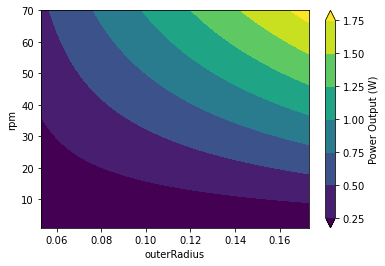

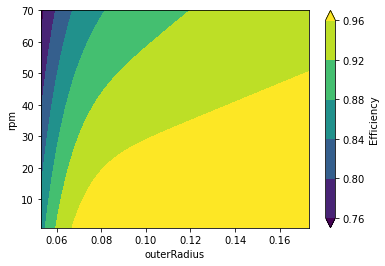

In [4]:
allowableSpaceToPlay = rToCasing-ringClearance-0.053 #0.053 is minimum case
outerRadiusRange = np.linspace(0.053, 0.053+allowableSpaceToPlay,100)
rpmRange = np.linspace(1,70,99)

efficiencyStore = np.zeros([len(outerRadiusRange),len(rpmRange)])
powerStore = np.zeros([len(outerRadiusRange),len(rpmRange)])

position,hiOutput = [0,0],0
bestInstance = 0
bestRelativeTipTangential = 0
for i in range(len(outerRadiusRange)):
    for j in range(len(rpmRange)):
        outerR = outerRadiusRange[i]
        eRPM = rpmRange[j]

        #reinitialise
        ShrimptonKJ = flowParameters()
        ShrimptonKJ.rotorDisc(0.016, outerR, discSpacing, Width,numberSpacing = discNumber - 1)
        vR, vT = velocityInlet(TotalMassFlowRate, density, Angle, Width, rToCasing, ShrimptonKJ)
        ShrimptonKJ.flowSpeed(vR, vT, eRPM)
        ShrimptonKJ.derived()

        firstODEinitial = ShrimptonKJ.relativeTipTangential
        secondODEinitial = 0
        rs = np.linspace(1,ShrimptonKJ.innerOuterRatio,100)
        sol = odeint(bothODE, [firstODEinitial,secondODEinitial], rs, args=(ShrimptonKJ,))
        efficiencyStore[i,j] = rotorEff(sol[:,0], rs, ShrimptonKJ)
        powerStore[i,j] = power(sol[:,0], rs, ShrimptonKJ)
        if powerStore[i,j]>hiOutput:
            position, hiOutput = [i,j], powerStore[i,j]
            bestRelativeTipTangential = ShrimptonKJ.relativeTipTangential
            bestInstance = ShrimptonKJ
print(f"maximum possible power output is at: {outerRadiusRange[position[0]]} m, {rpmRange[position[1]]} rpm, value: {hiOutput} W")

X,Y = np.meshgrid(outerRadiusRange,rpmRange)

fig = plt.figure()
ax = fig.gca()
CS = ax.contourf(X, Y, powerStore.transpose(), extend='both')
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Power Output (W)")
ax.set_xlabel("outerRadius")
ax.set_ylabel("rpm")

fig1 = plt.figure()
ax1 = fig1.gca()
CS1 = ax1.contourf(X, Y, efficiencyStore.transpose(), extend='both')
cbar1 = fig1.colorbar(CS1)
cbar1.ax.set_ylabel("Efficiency")
ax1.set_xlabel("outerRadius")
ax1.set_ylabel("rpm")

print(f"Optimised Settings:\nRem*:\t\t{ShrimptonKJ.reynoldMS}\nW0_bar:\t\t{bestRelativeTipTangential}")

firstODEinitial = bestInstance.relativeTipTangential
secondODEinitial = 0
rs = np.linspace(1,bestInstance.innerOuterRatio,100)
sol = odeint(bothODE, [firstODEinitial,secondODEinitial], rs, args=(bestInstance,))

maxOuterRadius = outerRadiusRange[position[0]]

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars


120.06807758368649  W
80.97835063476413  W
56.60730090336312  W
42.042039624655956  W
32.09438451329145  W
25.494115996099573  W
20.248823022560412  W
16.728077516406216  W
14.133342633604006  W
12.129358613625492  W
10.285701918849556  W
8.769268640081641  W
7.7643911171742  W


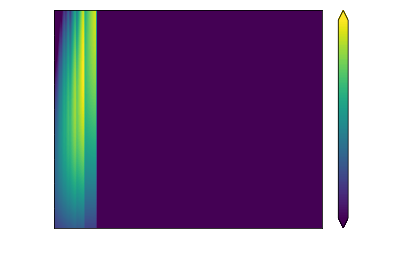

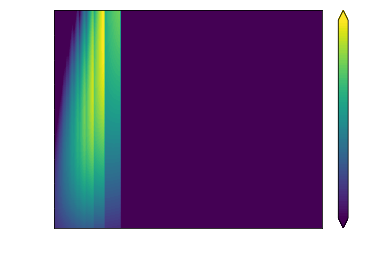

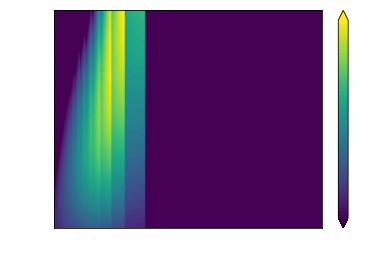

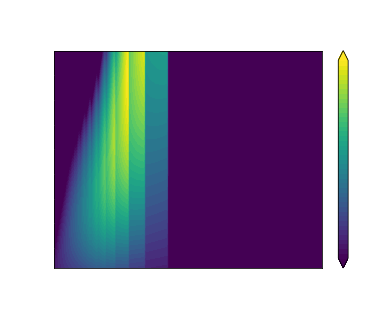

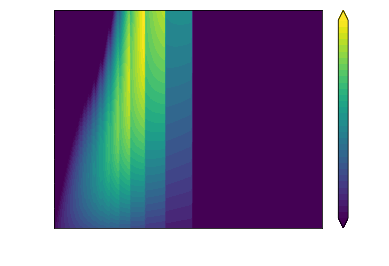

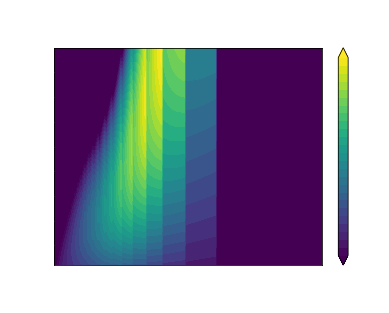

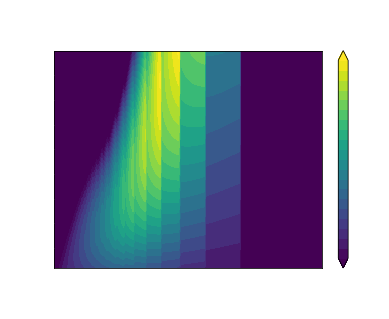

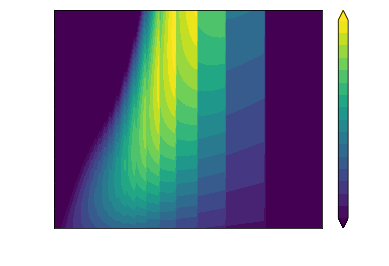

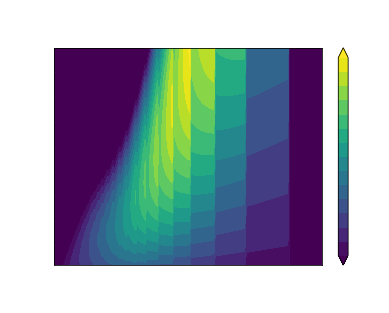

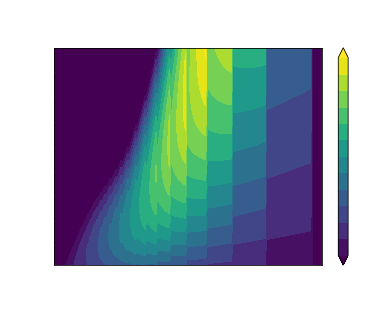

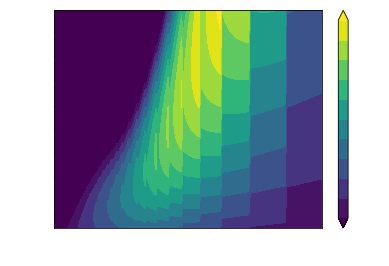

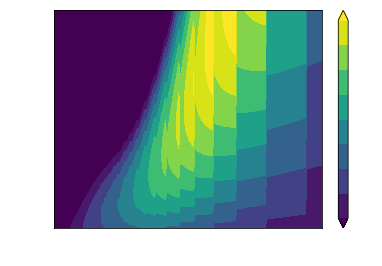

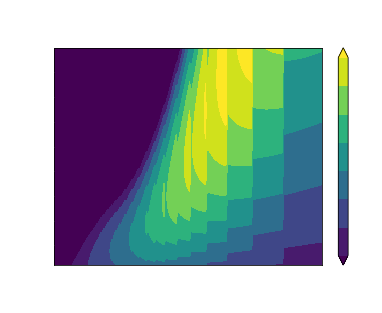

In [5]:
widthRange = np.arange(0.015,0.08,0.005)
for k in range(len(widthRange)):
    density = 997
    dynamicViscosity = 0.0008891
    kinematicViscosity = 8.917*10**-7
    TotalMassFlowRate = 1.3
    kfactor = 0.798

    rToCasing = 0.164
    ringClearance = 0.003

    minRadius = 0.016*3 #scalable
    Width = widthRange[k] #scalable
    h0 = kfactor*Width #scalable
    r0 = 0.2 #scalable
    r1 = rToCasing #scalable

    discThickness = 0.001 #1mm thickness for manufacturing
    wallSpace = 0.002 #2mm wall spacer
    discSpacing = 0.0002 #1mm gap


    rpmRange = np.linspace(300,2500,200)
    #widthRange = np.linspace(0.015, 0.05 ,200)
    scaleRange = np.linspace(1,10,200)

    powerStorage = np.zeros([len(scaleRange), len(rpmRange)])
    position,hiOutput = [0,0],0
    for i in range(len(scaleRange)):
        for j in range(len(rpmRange)):
            scale = scaleRange[i]
            eRPMV = rpmRange[j]

            h0_new = h0/scale
            Angle1 = flowAngle(Width/scale, r0/scale, h0_new)

            instance1 = flowParameters()
            instance1.rotorDisc(minRadius/scale, r1/scale, discSpacing, Width/scale ,numberSpacing \
                                = maxDiscNumber(Width/scale, discThickness, wallSpace, discSpacing) - 1)
            vR1, vT1 = velocityInlet(TotalMassFlowRate, density, Angle1, Width/scale, rToCasing/scale, instance1)
            instance1.flowSpeed(vR1, vT1, eRPMV)
            instance1.derived()

            rNP = np.linspace(1,instance1.innerOuterRatio,100)

            initialValue = instance1.relativeTipTangential
            secondinitialValue = 0
            solution = odeint(bothODE, [initialValue,secondinitialValue], rNP, args=(instance1,))
            output = power2(solution[:,0], rNP, instance1)
            powerStorage[i,j] = output
            if powerStorage[i,j]>hiOutput:
                position, hiOutput = [i,j], powerStorage[i,j]
    print(hiOutput, " W")

    X,Y = np.meshgrid(scaleRange,rpmRange)


    fig = plt.figure()
    ax = fig.gca()
    CS = ax.contourf(X, Y, powerStorage.transpose(), np.arange(0,int(hiOutput)+1,1),extend='both')
    cbar = fig.colorbar(CS)

    cbar.ax.set_ylabel(f"Power Output (W), Original width: {widthRange[k]}m")
    ax.set_xlabel("scale")
    ax.set_ylabel("rpm")

    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    cbar.ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    cbar.ax.tick_params(axis='y', colors='white')

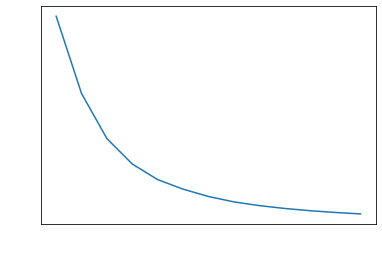

In [6]:
hiPowerList = np.array([
    21.54523712633813,
    13.529045160590096,
    8.848710336019773,
    6.214131719028278,
    4.594203228659987,
    3.605326524235603,
    2.842549591765516,
    2.2834489289219713,
    1.8974509160844382,
    1.6010076289917987,
    1.3685777529398744,
    1.1830682336905405,
    1.0327113283992968
]);
figl,axl = plt.subplots()
axl.plot(widthRange,hiPowerList)
axl.set_xlabel("width (m)")
axl.set_ylabel("highest attainable power (W)")
axl.xaxis.label.set_color('white')
axl.yaxis.label.set_color('white')
axl.tick_params(axis='x', colors='white')
axl.tick_params(axis='y', colors='white')

In [7]:
w0 = 0.025
w1 = 0.04
h0 = kfactor*w0
h1 = kfactor*w1

n0 = maxDiscNumber(w0, discThickness, wallSpace, discSpacing)
n1 = maxDiscNumber(w1, discThickness, wallSpace, discSpacing)

print(f"Angle:\t\t {90-flowAngle(w0, r0, h0)*180/pi},{90-flowAngle(w0, r0, h1)*180/pi}")


effectiveArea0 = 2*pi*rToCasing*w0
vRadial0 = TotalMassFlowRate/(effectiveArea0*density)
vTheta0 = vRadial0/tan(flowAngle(w0, r0, h0))

effectiveArea1 = 2*pi*rToCasing*w1
vRadial1 = TotalMassFlowRate/(effectiveArea1*density)
vTheta1 = vRadial1/tan(flowAngle(w1, r0, h1))

print(vTheta0, vTheta1)

testing = flowParameters()
testing.rotorDisc(0.016, maxOuterRadius, discSpacing, w0 ,numberSpacing 
                  = maxDiscNumber(w0, discThickness, wallSpace, discSpacing) - 1)
vR0, vT0 = velocityInlet(TotalMassFlowRate, density, flowAngle(w0, r0, h0), w0, rToCasing, testing)

testing.gasketSpacing = w1
testing.numberSpacing = maxDiscNumber(w1, discThickness, wallSpace, discSpacing) - 1
vR1, vT1 = velocityInlet(TotalMassFlowRate, density, flowAngle(w1, r0, h1), w1, rToCasing, testing)
print(vT0, vT1)

Angle:		 87.72081659784158,84.1822873140705
1.2717409883502384 0.49677382357431044
1.2717409883502384 0.49677382357431044
